# Image Classification

This notebook shows how to use AWS's ML infrastructure, SageMaker, to train and deploy a pretrained model to classify images, in this case images of different dog breeds. The objective of the project is not to create the best trained model, but rather demonstrate the techniques and tools that can be used to create, profile, debug, deploy and use a model. In that context the specific neural network chosen is not important.

I have also taken the opportunity to experiment with pytorch's new datapipes when accessing training and test data. This did mean I needed to use the latest releases of pytorch.

SageMaker's Debugger has been used to instrument training so that any issues can be more easily identified and corrected.


In [ ]:
%conda install pytorch torchvision torchaudio torchdata -c pytorch-nightly
%conda install -c conda-forge pandas
%conda install -c conda-forge sagemaker_containers
%conda install -c conda-forge sagemaker-python-sdk
%conda install -c conda-forge python-dotenv
%conda install -c conda-forge matplotlib
%conda install -cbconda-forge boto3
%conda install -c conda-forge iopath
%conda install pytorch torchvision torchaudio torchdata -c pytorch-nightly
%conda install -c conda-forge iopath


In [76]:
!pip install smdebug

In [304]:
import os.path
from os import path
import json
import logging

import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision.datasets.folder
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader

from PIL import ImageFile
from datetime import datetime

print(torch.__version__)


1.13.0.dev20220614


In [305]:

from dotenv import load_dotenv
import os
import boto3
# import aws packages 
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    ProfilerConfig,
    FrameworkProfile,
    DetailedProfilingConfig,
    DataloaderProfilingConfig,
    PythonProfilingConfig,
)

load_dotenv()
boto_session = boto3.Session(
    region_name='us-east-1',
    aws_access_key_id=os.getenv('aws_access_key_id'),
    aws_secret_access_key=os.getenv('aws_secret_access_key'))
print(boto_session)
s3 = boto_session.client('s3')

sagemaker_session = sagemaker.Session(boto_session=boto_session)
print(sagemaker_session)

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/data"

# role = sagemaker.get_execution_role()
# NOTE You can only use the get_execution_role when running,
# the notebook from within SageMaker (see https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html)
# As the notbook is generally being run locally I've had to resort to using a hardcoded role
# which I appreciate is not best practise
role = 'arn:aws:iam::249450185950:role/service-role/AmazonSageMaker-ExecutionRole-20220609T085020'


Session(region_name='us-east-1')


## Dataset
The dataset used is a collection of images of dogs of different breeds.
The folder structure is used to classify the images. The top level folders break them down into train, validation and test images and within each of these folders the images for a specific dog breed are contained in a folder for that breed.

Below you can see a sample of the images. You will note that the images are not all of the same size. They will need to be of the same size when using them against the model, so part of the transformation process will be to make sure this is the case.


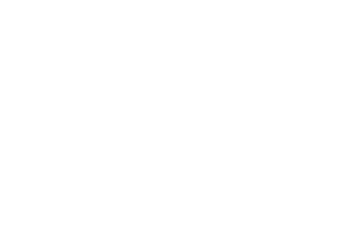

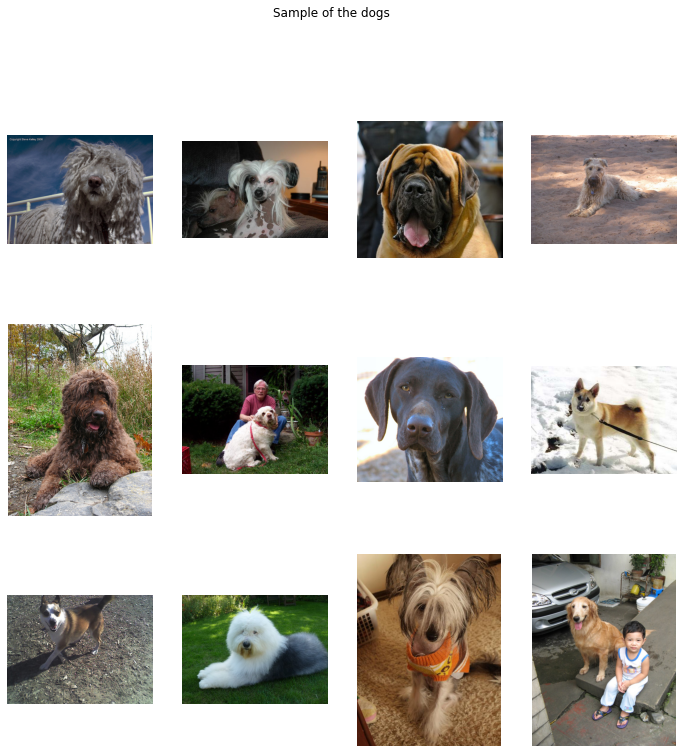

In [79]:
import matplotlib.pyplot as plt
import math

trans = transforms.Compose([
    transforms.ToTensor(),
    ])

data = datasets.ImageFolder(os.path.join('data/dogImages', 'train'), transform=trans)
loader = DataLoader(data, shuffle=True)

plt.axis('off')
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12,12))
fig.suptitle('Sample of the dogs')

num_images = 12
images_per_row = 4

for i, (d, label) in enumerate(loader):
    img = np.moveaxis(d[0].numpy(), 0, -1)
    r, c = int(i / images_per_row), i % images_per_row
    axs[r, c].imshow(img)
    axs[r,c].axis('off')
    if i == (num_images - 1):
        break


### Downloading data

I've created some functions to download the images if they have not already been downloaded, as well to upload the images to S3, if they have not already been uploaded.

In [56]:


def download_dog_images():
    # check if not already downloaded
    data_folder='dogImages'
    dpath = f"data/{data_folder}"
    if path.exists(dpath):
        return dpath
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    !mv dogImages data/
    return dpath
    
# Command to download and unzip data
def get_s3_data_url(bucket=bucket, prefix=prefix, data_folder='dogImages'):
    print('get_data_url', bucket, prefix, data_folder)
    result = s3.list_objects_v2(Bucket=bucket, Prefix=f'{prefix}/{data_folder}')
    if 'Contents' in result:
        print('folder already exists so don\'t need to upload')
        url = f's3://{bucket}/{prefix}/{data_folder}'
    else:
        url = sagemaker_session.upload_data(path=f'data/{data_folder}', bucket=bucket, key_prefix=f'{prefix}/{data_folder}')

    print("S3 path): {}".format(url))
    return url


In [57]:
download_dog_images()

s3_url = get_s3_data_url(bucket=bucket, prefix=prefix, data_folder='dogImages')
print('s3 url', s3_url)

get_data_url sagemaker-us-east-1-249450185950 sagemaker/data dogImages
folder already exists so don't need to upload
S3 path): s3://sagemaker-us-east-1-249450185950/sagemaker/data/dogImages
s3 url s3://sagemaker-us-east-1-249450185950/sagemaker/data/dogImages


## Loading data using Pytorch datapipes

Pytorch have recently introduced a new way of loading data, namely ***Datapipes*** that are a drop in replacement for datasets and can be used with the current dataloaders.
One appeal of using datapipes was to experiment with their built-in support for S3, namely S3FileLister and S3FileLoader. By using these it shouldn't be necessary to download the data to local storage, but rather accessed it directly from S3.
Additionally as this appears to be the new way to manage data in pytorch I thought it would be useful to experiment with it.

I only used this datapipe implementation in a very limited way, namely to calculated the mean and standard deviation of each dataset (train, valid and test) so that the images could be normalized correctly.

Note: this did mean that I needed to install the very latest versions of pytorch

In [60]:
# This code is based on the example code in torchdata https://github.com/pytorch/data/blob/main/examples/vision/imagefolder.py

# This is an implementation of ImageFolder (https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) implemented using datapipes


from PIL import Image
from io import BytesIO

from torchdata.datapipes.iter import FileLister, HttpReader, IterDataPipe
from torchdata.datapipes.iter import S3FileLister, S3FileLoader
from torchdata.datapipes.utils import StreamWrapper


def get_category_name(path, root):
    rel_path = os.path.relpath(path, start=root)
    elements = rel_path.split(os.sep)
    return elements[0]

class ObtainCategories(IterDataPipe):
    def __init__(self, source_dp, root, parse_category_fn=get_category_name) -> None:
        self.source_dp = source_dp
        self.parse_category_fn = parse_category_fn
        self.root = root

    def __iter__(self):
        categories = set()
        for path in self.source_dp:
            categories.add(self.parse_category_fn(path, self.root))
        cat_to_id = {name: i for i, name in enumerate(sorted(categories))}
        yield cat_to_id

class AttributeCategories(IterDataPipe):
    def __init__(self, listfiles_dp, categories_dp, root, parse_category_fn=get_category_name) -> None:
        self.listfiles_dp = listfiles_dp
        self.categories_dp = categories_dp
        self.parse_category_fn = parse_category_fn
        self.root = root

    def __iter__(self):
        for categories in self.categories_dp:
            cat_to_dp = categories
        for data in self.listfiles_dp:
            if isinstance(data, tuple):
                category = cat_to_dp[self.parse_category_fn(data[0], self.root)]
                yield data + (category,)
            else:
                category = cat_to_dp[self.parse_category_fn(data, self.root)]
                yield (data, category)

def with_default_loader(x):
    #print('with_default_loader', x)
    # x[0] - file location
    # x[1] - label
    return (torchvision.datasets.folder.default_loader(x[0]), x[1])

def with_default_filelister(root, recursive=True):
    return FileLister(root=root, recursive=recursive)

def with_s3_loader(x):
    dp_s3_files = S3FileLoader([x[0]])
    stream = next(iter(dp_s3_files))[1]
    image = Image.open(stream)
    return (image, x[1])

def with_s3_filelister(s3urls, recursive=True):
    return S3FileLister(s3urls)

def do_transform(x, transform):
    # print('do transform', x)
    # x[0] PIL.Image.Image
    # x[1] label
    return (transform(x[0]), x[1])


def MyImageFolder(root, transform=None, from_s3=False):
    if from_s3:
        print('using S3 files')
        filelister = with_s3_filelister
        fileloader = with_s3_loader
    else:
        print('using local files')
        filelister = with_default_filelister
        fileloader = with_default_loader
            
    print('USE_FORK_DATAPIPE', USE_FORK_DATAPIPE)
    if not USE_FORK_DATAPIPE:
        # Yes, we had to scan files twice. Alternativelly it is possible to use
        # `fork` DataPipe, but it will require buffer equal to the size of all
        # full file names
        # TODO(125): Make sure that `fork` complains when buffer becomes
        # too large
        list_files_0 = filelister(root, recursive=True)
        list_files_1 = filelister(root, recursive=True).sharding_filter()
#        list_files_0 = with_defaultfilelister(root=root, recursive=True)
#        list_files_1 = with_default_filelister(root=root, recursive=True).sharding_filter()
    else:
        list_files_0, list_files_1 = filelister(root, recursive=True).fork(2)
        list_files_1 = list_files_1.sharding_filter()

    categories = ObtainCategories(list_files_0, root)
    with_categories = AttributeCategories(list_files_1, categories, root)
#    using_loader = with_categories.map(lambda x: with_default_loader(x))
    using_loader = with_categories.map(lambda x: fileloader(x))

    transformed = using_loader.map(lambda x: do_transform(x, transform))
    return transformed

def get_categories(root, from_s3=False):
    if from_s3:
        print('using S3 files')
        filelister = with_s3_filelister
        fileloader = with_s3_loader
    else:
        print('using local files')
        filelister = with_default_filelister
        fileloader = with_default_loader

    list_files_0 = filelister(root, recursive=True)
    categories_dp = ObtainCategories(list_files_0, root)
    return next(iter(categories_dp))




### Normalizing the images
It is important to normalize images in order that training works effectively
To do this for each RGB channel (red, green, blue) the mean is subtracted from the value and divided by the standard deviation
normalized_x = (x - mean)/std  

In [61]:
# calculate mean and standard deviation of images
# these values are then used to normalize the images
def dataset_info(dataset):
    loader = DataLoader(dataset, 
                        shuffle=False,
                        batch_size=BATCH_SIZE, 
                        num_workers=NUM_WORKERS)
    nimages = 0
    mean = 0.0
    var = 0.0
    for i_batch, batch_target in enumerate(loader):
        batch = batch_target[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        # calculate the means of the 2nd dimension, i.e. channel
        # and then sum the means across the batches
        mean += batch.mean(2).sum(0) 
        # variances can be added (rather than standard deviations)
        var += batch.var(2).sum(0)

    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    return (mean.tolist(), std.tolist())

In [59]:
# initialize some useful constants

IMAGES_ROOT = os.path.join("data", "dogImages")
TRAIN_IMAGES_ROOT = os.path.join("data", "dogImages", "train")
VALIDATE_IMAGES_ROOT = os.path.join("data", "dogImages", "valid")
TEST_IMAGES_ROOT = os.path.join("data", "dogImages", "test")

USE_FORK_DATAPIPE = False
BATCH_SIZE = 64

NUM_WORKERS = 0
# if this is not set then the data loader throw an exception
ImageFile.LOAD_TRUNCATED_IMAGES = True
IMAGE_SIZE = 224
torch.manual_seed(1)

## Hyperparameter Tuning

Hyperparamter tuning is a technique to find the best hyperparameters to train your model with. Whilst there are many hyperparameters I have decided to just tune three parameters:
- learning rate
- batch size
- optimizer

which according to this article [Tune an Image Classification Model](https://docs.aws.amazon.com/sagemaker/latest/dg/IC-tuning.htmlhttps://docs.aws.amazon.com/sagemaker/latest/dg/IC-tuning.html) have the biggest impact for image classification jobs.



### Define parameters to tune and their ranges

In [64]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "optimizer": CategoricalParameter(['sgd', 'asgd', 'adam', 'rmsprop']),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


### Create a PyTorch Estimator

In [275]:

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

# note the backend 'gloo' - this applies when training is distributed
# over a number of machines specifies how these machines are communicating with each other
# for more information see https://pytorch.org/tutorials/intermediate/dist_tuto.html
estimator = PyTorch(
    sagemaker_session=sagemaker_session,
    entry_point="hpo.py",
    role=role,
    py_version='py3',
    framework_version="1.8.0",
    instance_count=1,
#    instance_type="ml.c5.2xlarge", # some training runs failed when hperparameter tuning 
#    with message - ClientError: Please use an instance type with more memory, or reduce the size of training data processed on an instance
    instance_type="ml.c5.4xlarge",   
    hyperparameters={"epochs": 1, 
                     "backend": "gloo",
                     "batch-size": 64,
                    },
    container_log_level=logging.DEBUG,
)


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=9,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


### Test training job before running tuner

In [265]:
# test the training job

wait = True
estimator.fit(s3_url, wait=wait)

# save the jobname so that we can easily recreate the tuner at some future point
training_job_name = estimator.latest_training_job.name
print('training_job_name', training_job_name)
now = datetime.now()
print(now.isoformat())
training_info = {'training': {'job_name': estimator.latest_training_job.name,
                              'date': now.isoformat()}
                }

with open('training_info.json', 'w') as json_file:
          json.dump(training_info, json_file)

2022-07-20 13:18:14 Starting - Starting the training job...
2022-07-20 13:18:38 Starting - Preparing the instances for trainingProfilerReport-1658323093: InProgress
......
2022-07-20 13:19:38 Downloading - Downloading input data...............
2022-07-20 13:22:19 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-20 13:22:18,599 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-20 13:22:18,600 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-20 13:22:18,601 botocore.hooks DEBUG    Changing event name from creating-client-class.iot-data to creating-client-class.iot-data-plane
2022-07-20 13:22:18,603 botocore.hooks DEBUG    Changing event name from before-call.apigateway to before-call.api-gateway
2022-07-20 13:22:18,603 botocore.hooks DEBUG    Changing event name

### Run hyperparameter tuner to determine best hyperparameters to use

In [68]:
tuner.fit(s3_url)

# save the jobname so that we can easily recreate the tuner at some future point
tuning_job_name = tuner.latest_tuning_job.name
print('tuning_job_name', tuning_job_name)

now = datetime.now()
print(now.isoformat())
training_info['tuning'] = {'job_name': tuner.latest_tuning_job.name,
                           'best_training_job': tuner.best_training_job(),
                              'date': now.isoformat()}

with open('training_info.json', 'w') as json_file:
          json.dump(training_info, json_file)


...........................................................................................................................................................................................................................................................................................................................................................................................................................!
tuning_job_name pytorch-training-220718-1333
2022-07-18T14:09:12.760398


### Save details of the tuning job

In [88]:

best_estimator = tuner.best_estimator(best_training_job={'TrainingJobName':tuner.best_training_job()})

#Get the hyperparameters of the best trained model
training_info['tuning']['best_hyperparameters'] = best_estimator.hyperparameters()
with open('training_info.json', 'w') as json_file:
          json.dump(training_info, json_file)
best_estimator.hyperparameters()



2022-07-18 13:03:00 Starting - Preparing the instances for training
2022-07-18 13:03:00 Downloading - Downloading input data
2022-07-18 13:03:00 Training - Training image download completed. Training in progress.
2022-07-18 13:03:00 Uploading - Uploading generated training model
2022-07-18 13:03:00 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'backend': '"gloo"',
 'batch-size': '"32"',
 'epochs': '1',
 'lr': '0.03084365365783057',
 'optimizer': '"asgd"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-07-18-12-33-41-130"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-249450185950/pytorch-training-2022-07-18-12-33-41-130/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

Note: based on https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

I'm using the hyperparameters from the tuning job to create an estimator that is configured to record profile and debugging information. The associated script (train_model.py) includes hooks to the debugger.

### Create estimator with tuned hyperparameters and profiling and debugging active

## Model Profiling and Debugging

Note: based on https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

I'm using the hyperparameters from the tuning job to create an estimator that is configured to record profile and debugging information. The associated script (train_model.py) includes hooks to the debugger.

### Create estimator with tuned hyperparameters and profiling and debugging active

In [308]:
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)


debug_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

debug_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

hps = best_estimator.hyperparameters()

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(),
)

# Note the hyparameters from best_estimator.hyperparameters() are enclosed in double-quotes, not sure why
estimator = PyTorch(
    sagemaker_session=sagemaker_session,
    entry_point="train_model.py",
    source_dir='src',
    role=role,
    py_version='py3',
    framework_version="1.8.0",
    instance_count=1,
#    instance_type="ml.c5.2xlarge", # some training runs failed when hperparameter tuning 
#    with message - ClientError: Please use an instance type with more memory, or reduce the size of training data processed on an instance
    instance_type="ml.c5.4xlarge",    
    hyperparameters={"epochs": 5, 
                     "backend": hps['backend'].replace('"', ""),
                     "batch-size": int(hps['batch-size'].replace('"', "")),
                     "test-batch-size": 100,
                     "lr": float(hps['lr'].replace('"', "")),
                     "optimize": hps['optimizer'].replace('"', ""),
                    },
    profiler_config=profiler_config,
    debugger_hook_config=debug_hook_config,
    rules=debug_rules,
    container_log_level=logging.DEBUG,
)


### Fit estimator

In [309]:
estimator.fit(s3_url, wait=True)



2022-07-21 08:15:56 Starting - Starting the training job...
2022-07-21 08:16:11 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport-1658391356: InProgress
......
2022-07-21 08:17:28 Downloading - Downloading input data............
2022-07-21 08:19:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-21 08:19:31,685 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-21 08:19:31,687 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-21 08:19:31,688 botocore.hooks DEBUG    Changing event name from creating-client-class.iot-data to creating-client-class.iot-data-plane
2022-07-21 08:19:31,689 botocore.hooks DEBUG    Changing event name from before-

### Get results from training

In [310]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'pytorch-training-2022-07-21-08-15-54-455',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:249450185950:training-job/pytorch-training-2022-07-21-08-15-54-455',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-249450185950/pytorch-training-2022-07-21-08-15-54-455/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'backend': '"gloo"',
  'batch-size': '32',
  'epochs': '5',
  'lr': '0.03084365365783057',
  'optimize': '"asgd"',
  'sagemaker_container_log_level': '10',
  'sagemaker_job_name': '"pytorch-training-2022-07-21-08-15-54-455"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-249450185950/pytorch-training-2022-07-21-08-15-54-455/source/sourcedir.tar.gz"',
  'test-batch-size': '100'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.

In [311]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(100)

### URLs to the corresponding processing job logs in CloudWatch


In [312]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
    """Helper function to get the rule job name with correct casing"""
    return "{}-{}-{}".format(
        training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
    )


def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(
        region, region, rule_job_name
    )


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]

    result = {}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(
                training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"]
            )
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(
                rule_job_name, region
            )
    return result


get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://None.console.aws.amazon.com/cloudwatch/home?region=None#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2022-07-2-VanishingGradient-65544981;streamFilter=typeLogStreamPrefix',
 'Overfit': 'https://None.console.aws.amazon.com/cloudwatch/home?region=None#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2022-07-2-Overfit-68117069;streamFilter=typeLogStreamPrefix',
 'Overtraining': 'https://None.console.aws.amazon.com/cloudwatch/home?region=None#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2022-07-2-Overtraining-bb122630;streamFilter=typeLogStreamPrefix',
 'PoorWeightInitialization': 'https://None.console.aws.amazon.com/cloudwatch/home?region=None#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2022-07-2-PoorWeightInitialization-db0dfd61;streamFilter=typeLogStreamPrefix'}

### Create an SMDebug trial object and retrieve saved output tensors


In [313]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-07-21 09:38:23.544 MarkMacMini.local:14777 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-249450185950/pytorch-training-2022-07-21-08-15-54-455/debug-output


### Saved output tensors

In [314]:
trial.tensor_names()


[2022-07-21 09:38:28.007 MarkMacMini.local:14777 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-07-21 09:38:29.120 MarkMacMini.local:14777 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/SqueezeNet_classifier.1.bias',
 'gradient/SqueezeNet_classifier.1.weight',
 'gradient/SqueezeNet_features.0.bias',
 'gradient/SqueezeNet_features.0.weight',
 'gradient/SqueezeNet_features.10.expand1x1.bias',
 'gradient/SqueezeNet_features.10.expand1x1.weight',
 'gradient/SqueezeNet_features.10.expand3x3.bias',
 'gradient/SqueezeNet_features.10.expand3x3.weight',
 'gradient/SqueezeNet_features.10.squeeze.bias',
 'gradient/SqueezeNet_features.10.squeeze.weight',
 'gradient/SqueezeNet_features.12.expand1x1.bias',
 'gradient/SqueezeNet_features.12.expand1x1.weight',
 'gradient/SqueezeNet_features.12.expand3x3.bias',
 'gradient/SqueezeNet_features.12.expand3x3.weight',
 'gradient/SqueezeNet_features.12.squeeze.bias',
 'gradient/SqueezeNet_features.12.squeeze.weight',
 'gradient/SqueezeNet_features.3.expand1x1.bias',
 'gradient/SqueezeNet_features.3.expand1x1.weight',
 'gradient/SqueezeNet_features.3.expand3x3.bias',
 'gradient/SqueezeNet_features.3.e

### Check the number of steps saved in the different training phases


In [315]:
train_steps = len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))
eval_steps = len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))
print('train steps', train_steps)
print('eval steps', eval_steps)


train steps 11
eval steps 15


### Functions to log and plot the output tensors


In [316]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="Val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


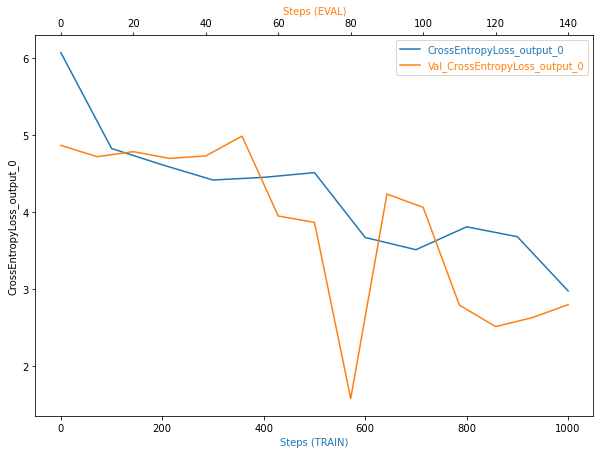

In [317]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


### Download, open, and display the ProfilerReport HTML file


In [318]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
!aws configure set s3.signature_version s3v4
!aws s3 ls {rule_output_path} --recursive
!aws s3 cp {rule_output_path} ./ --recursive


2022-07-21 09:30:27     376605 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-report.html
2022-07-21 09:30:26     224582 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-report.ipynb
2022-07-21 09:30:21        192 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-reports/BatchSize.json
2022-07-21 09:30:21        200 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-21 09:30:21       2109 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-reports/Dataloader.json
2022-07-21 09:30:21        127 pytorch-training-2022-07-21-08-15-54-455/rule-output/ProfilerReport-1658391356/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-21 09:30:21        199 pytorch-training-2022-07-21-0

In [342]:
import os
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Dealing with issues

The only issue identified was to increase the number of dataloader processes.

The rules that we are monitoring for are:
- vanishing gradient
- overfitting
- overtraining
- poor weight initialization

#### Vanishing gradient
Vanishing gradient is when a neural network is unable to propagate useful gradient information to to layers near the input end of the network. This means the network is unable to learn from the given dataset. A common solution to this problem is to use the rRectified Linear Unit activation function (ReLU).

#### Overfitting
Overfitting means that the model is too closely aligned to the input data, but does not generalise well to other data given. There are a number of techniques that could be used to avoid overfitting:

***Increase the training data***

Although often not possible, increasing the training data is likely to help with overfitting as more examples are likely to provide greater variety.

***Reduce complexity of the model***

A greater number of layers enables the model to more closely fit the training data, this may result in a accurate model, but it may also result in one that closely matches the training data, but does not generalise well.

***Other techniques that can be tried include***:
- Weight Regularization: weight regularization, or weight decay is where the model is penalised based on the magnitude weights.
- Activity Regularization: Penalise the model during training base on the magnitude of the activations.
- Weight Constraint: Constrain the magnitude of weights to be within a range or below a limit.
- Dropout: Probabilistically remove inputs during training.
- Noise: Add statistical noise to inputs during training.

#### Overtraining
Overtraining means that the the model is overfitting the test data The most common solution is early stopping. So to stop training when the performance of the validation starts to degrade.


## Model Deploying

In [331]:
from sagemaker.model_monitor import DataCaptureConfig


data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri='s3://sagemaker-us-east-1-249450185950/data-capture/'
)

predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type="ml.c5.4xlarge",
                             data_capture_config=data_capture_config
)


-------------!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


number of test images 836
Label 15
Prediction 15
Prdiction is correct


(None,)

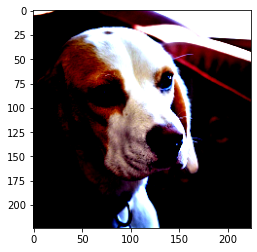

In [328]:
import matplotlib.pyplot as plt

fname = 'dog_images_mean_std.json'
with open(fname) as json_file:
    mean_std = json.load(json_file)        


trans = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean_std['mean']['test'], mean_std['std']['test'])
    ])


data = datasets.ImageFolder(os.path.join('data/dogImages', 'test'), transform=trans)

print('number of test images', len(data))

loader = DataLoader(data, shuffle=True)

# get first image
data, label = next(iter(loader))
images = data

first_label = label.numpy()[0]
first_image = images[0]

img = np.moveaxis(first_image.numpy(), 0, -1)
plt.imshow(img)
print('Label', first_label)
response = predictor.predict(images)
predicted_label = np.array(response[0]).argmax()
print('Prediction', predicted_label)
print(f'Prdiction is {"correct" if first_label == predicted_label else "incorrect"}'), 

In [341]:
# Shutdown endpoint
predictor.delete_endpoint()

## Appendix

### Updating script

During development there were times where I wanted to modify the script (hpo.py or test_model.py), but didn't want to rerun an estimator. I used deploy on the model itself to do this

In [299]:
print(job_name)
#estimator = PyTorch.attach(job_name, sagemaker_session=sagemaker_session)
model_uri = estimator.model_data
print(model_uri)
model = PyTorchModel(model_data=model_uri,
                     role=role,
                     framework_version='1.8.0',
                     py_version='py3',
                     entry_point='train_model.py',
                     source_dir='src',
                    predictor_cls=sagemaker.pytorch.model.PyTorchPredictor,
                    sagemaker_session=sagemaker_session)

predictor = model.deploy(initial_instance_count=1,
                         instance_type="ml.c5.4xlarge",
)


pytorch-training-2022-07-20-15-49-29-109
s3://sagemaker-us-east-1-249450185950/pytorch-training-2022-07-20-15-49-29-109/output/model.tar.gz
------!

### Model summary

In [ ]:
!pip install torchsummary

In [340]:
import sys
sys.path.insert(0,'src')
from hpo import net

from torchsummary import summary

model = net(feature_extract=False, use_pretrained=True)
model = torch.nn.DataParallel(model)

summary(model, (3, 224, 224))


/usr/local/anaconda3/envs/ml-pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,